# Analysis on US Crime Data

We will be analyzing a dataset describing 1973 violent crime rates by US State. The crimes considered are assault, murder, and rape. Also included is the percent of the population living in urban areas.

The dataset is available as *USarrests.csv*. The dataset has 50 observations (corresponding to each state) on 4 variables: 
1. Murder: Murder arrests (per 100,000 residents)
2. Assault: Assault arrests (per 100,000 residents)
3. UrbanPop: Percent urban population
4. Rape: Rape arrests (per 100,000 residents)

You can read more about the dataset [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html). 
    
 Our goal is to use unsupervised methods to understand how violent crimes differ between states. 

In [87]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 

import nltk
from nltk.corpus import stopwords

import re

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

## Preliminary Exploratory Analysis

In [88]:
df = pd.read_csv('USarrests.csv')
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


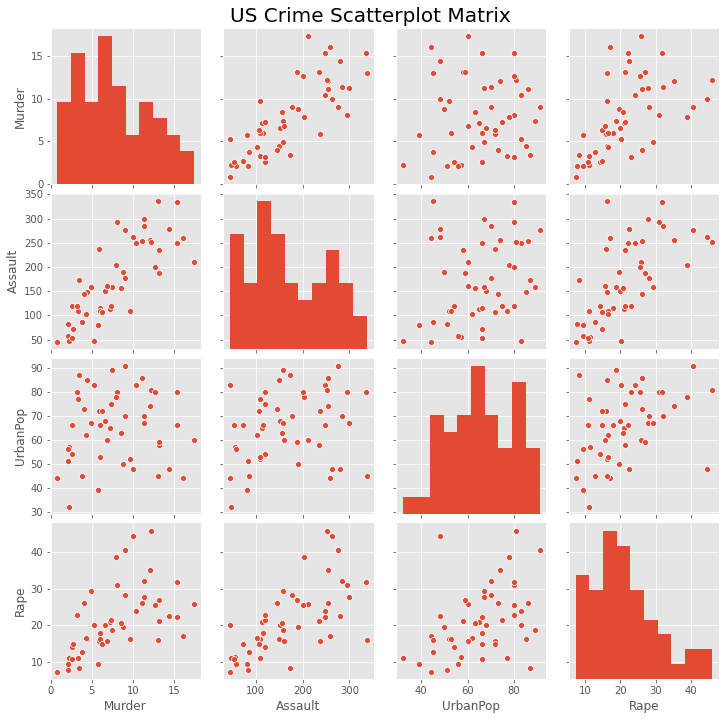

In [89]:
rel = sns.pairplot(df)

# #move title up
rel.fig.subplots_adjust(top=.95)

#add overall title
rel.fig.suptitle('US Crime Scatterplot Matrix', fontsize = 20)

plt.savefig('us-crime-scatter.png')

In [90]:
df.corr()

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


In our preliminary analysis, we can see that Murder and Assault is highly positively correlated with a correlation of 0.8. There are some correlation with Rape + Assault and Rape + Murder but not as strong. There is almost no correlation between the Urban Population with Murder and Assault.

## Analysis with Cluster Heat Map

Clustering is basically grouping data based on relationships among the variables in the data. Clustering algorithms help in getting structured data in unsupervised learning.

Heatmaps are a great way of finding the collinearity of the data and help distinguish which rows or columns should or should not be included as part of your results. If the objective is to create several predictor models, this will help filter any dependent variables that are collinear.


In [91]:
df1 = df.drop(columns = {'Unnamed: 0'})
df1.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


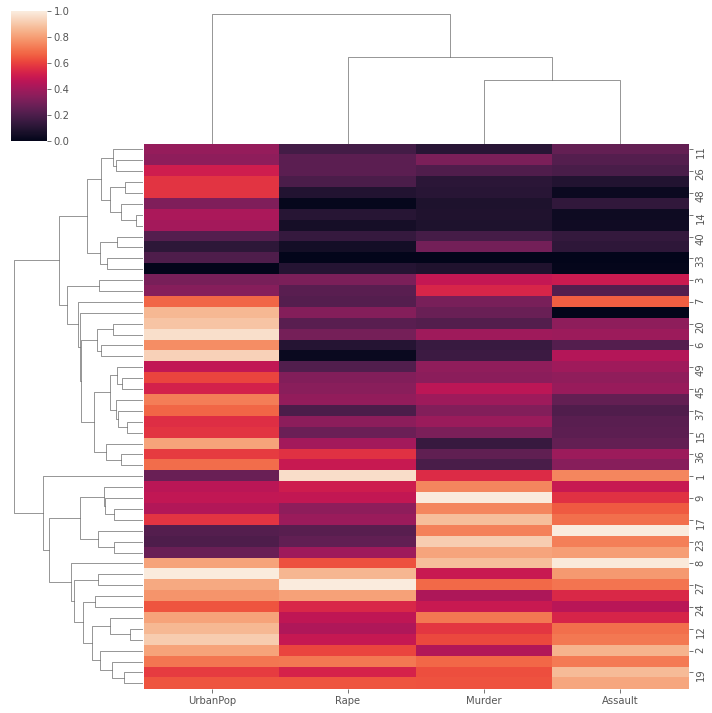

In [92]:
rel2 = sns.clustermap(df1, standard_scale=1)

#move title up
# rel2.fig.subplots_adjust(top=.95)

#add overall title
# rel2.fig.suptitle('US Crime Cluster Heat Map', fontsize = 20)

plt.savefig('us-crime-heat.png')

In our cluster heat map analysis, we can visualize that Urban Population has does not necessarily correlate with Murder and Assault. Which means that states with a higher population does not determine murders or assaults. There is some relationship between the number of Rapes, Murders, and Assaults. We can also see that Murder and Assault are similar within the states.

## Visualizing Data using Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is one of the most used unsupervised machine learning algorithms across a variety of applications: exploratory data analysis, dimensionality reduction, information compression, and data de-noising. PCA is a dimensionality reduction technique that transforms a set of features in a dataset into a smaller number of features called principal components while at the same time trying to retain as much information in the original dataset as possible. Since we have 4 different variables, we have a fourth dimensional data set. PCA can take 4 or more variables and make a two-dimensional PCA plot. PCA can also tell us which variable is the most valuable for clustering the data. It also can tell us how accurate the two-dimensional graph is. 

Principal Component Analysis calculates the average of each variable and using this average, finds the center of the data. It then shifts the data so that the center of the data is at the origin. From here, we input principal components. The principal components are vectors, but they are not chosen at random. The first principal component (PC1) is computed so that it explains the greatest amount of variance in the original features. Thus, it minimizes the distance between each data point on the graph (Sum of Squared) so PC1 is a linear combination of variables. It uses a scaled vector called the "Eigenvector" or "Singular Vector" for PC1. The sum of squared distances for the best fit line is the Eigenvalue for PC1. The second component (PC2) is orthogonal to the first, and it explains the greatest amount of variance left after the first principal component. Then we find PC3 and PC4 which are perpendicular to PC1 and PC2 that goes through the origin. The number of PCs is either the number of variables or the number of samples, whichever is smaller. 

Once all the principal components are figured out, you can use the eigenvalues to determine the proportion of variation that each PC accounts for. Then you can create a scree plot which is a graphical representation of the percentages of variation that each PC accounts for.



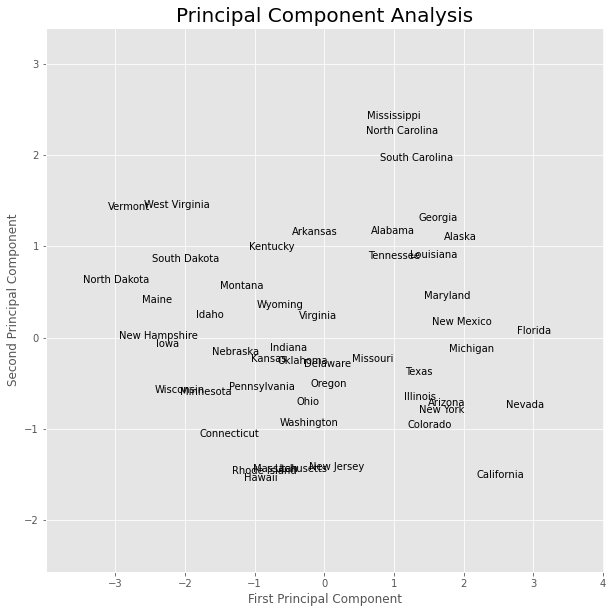

Explained Variance Ratios of the PCA: [0.62006039 0.24744129 0.0891408  0.04335752]


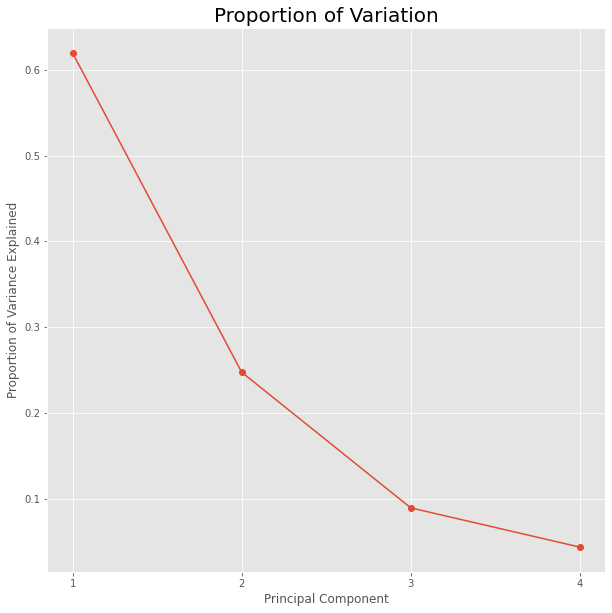

In [93]:
# Drops first state column
X = scale(df.drop(['Unnamed: 0'],axis=1).values)

# PCA Model
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)
df_plot = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_plot.head()
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

# Recenters Data
for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title('Principal Component Analysis', fontsize = 20)
plt.savefig('pca.png')
plt.show()

# Scree Plot
var_ratio = pca_model.explained_variance_ratio_
print('Explained Variance Ratios of the PCA:', var_ratio)

plt.plot([1,2,3,4], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Proportion of Variation', fontsize = 20)
plt.xticks([1,2,3,4])
plt.savefig('scree-plot.png')
plt.show()

In this scree plot, we can see that PC1, PC2, and PC3 account for the vast majority of the variation. This means that a three dimensional graph, using just PC1, PC2, and PC3 would be a good approximation of this four dimensional graph since it would account for 95.66% of the variation in the data. Also a two dimensional graph would account for 86.76% of the variation in the data.

## K-Means Cluster Analysis

We will now cluster the states into four clusters using k-means. K-means cluster identify initial clusters and calculate the variances between each cluster or the Euclidean distance. It clusters all the remaining points, calculates the mean of each cluster and then reclusters based on the new means. It repeats until the clusters no longer change. It restarts the cluster until it finds the best overall cluster. It does as many reclustering as we tell it to do. It then comes back and returns to the optimal one.


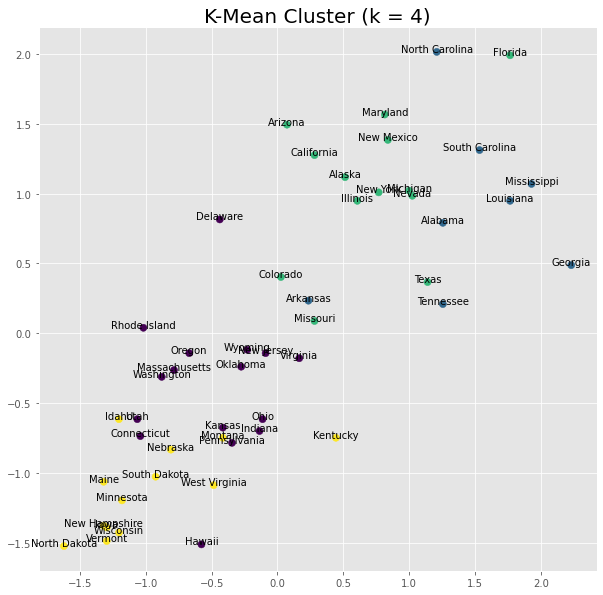

Cluster 1: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']
Cluster 2: ['Alabama', 'Arkansas', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
Cluster 3: ['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 4: ['Idaho', 'Iowa', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']


In [94]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
fig,ax1 = plt.subplots()

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)

plt.title('K-Mean Cluster (k = 4)', fontsize = 20)
plt.savefig('k-mean-cluster.png')
plt.show()

df2 = df['Unnamed: 0'].values
cluster1 = df2[kmeans.labels_==0].tolist()
cluster2 = df2[kmeans.labels_==1].tolist()
cluster3 = df2[kmeans.labels_==2].tolist()
cluster4 = df2[kmeans.labels_==3].tolist()
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)
print('Cluster 3:', cluster3)
print('Cluster 4:', cluster4)

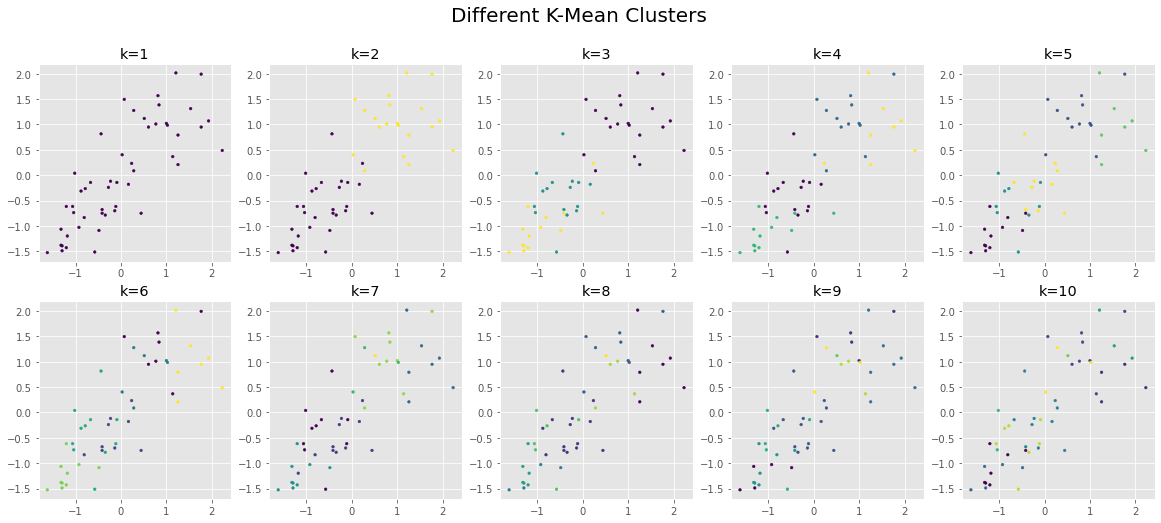

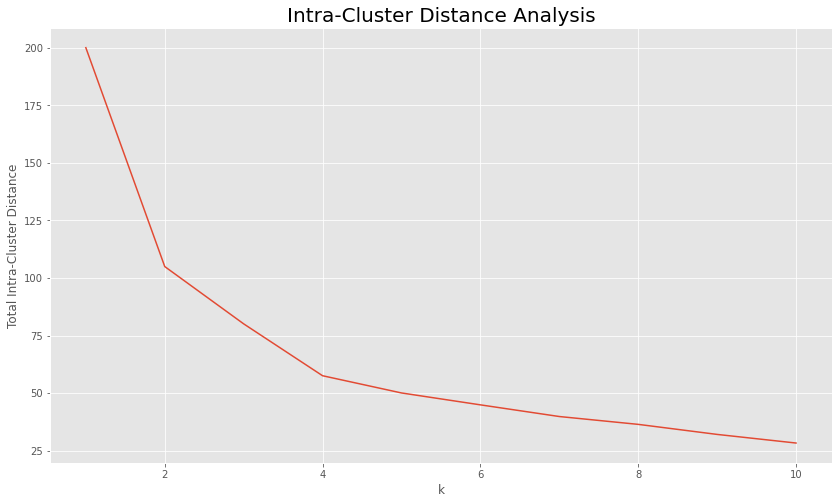

In [95]:
ks = range(1,11)
scores = []

fig, axs = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle('Different K-Mean Clusters', fontsize = 20)

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

    subplot = axs[int((k-1)/5)][(k-1)%5]
    subplot.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", s=7);
    subplot.set_title("k="+str(k))

plt.savefig('different-k-mean.png')

fig = plt.figure(figsize=(14, 8))
plt.plot(ks, scores)
plt.title('Intra-Cluster Distance Analysis', fontsize = 20)
plt.ylabel('Total Intra-Cluster Distance')
plt.xlabel('k')
plt.savefig('intra-cluster-distance.png')
plt.show()

**Interpretation for best K:** We can see that the total intra-cluster distance is large for $k = 1$ and decreases as we increase $k$, until $k=4$, after which it tapers off and gets only marginally smaller. The slope becomes constant after $k = 4$. This indicates that $k=4$ is a good choice.

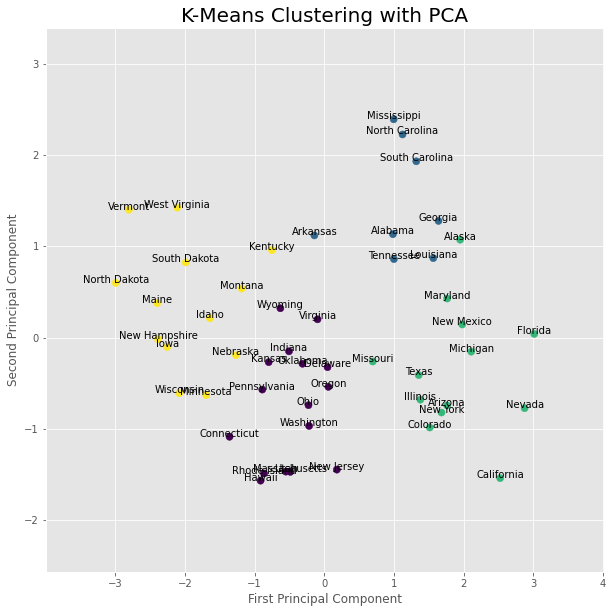

In [96]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_kmeans, s=50)

for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('K-Means Clustering with PCA', fontsize = 20)
plt.savefig('kmean-pca.png')
plt.show()

**Interpretation for PCA and K-Means**: Based on the updated PCA plot with the clustering, it is consistent with the clustering with the points split into four sections.

## Hierarchical Cluster Analysis

We will now use hierarchical clustering with complete linkage and Euclidean distance, cluster the states into four clusters. Then we will visualize the cluster results on top of the first two components.

Hierarchical clustering is often associated with heatmaps. It organizes the rows and columns based on similarity. This makes it easy to see correlations in the data.


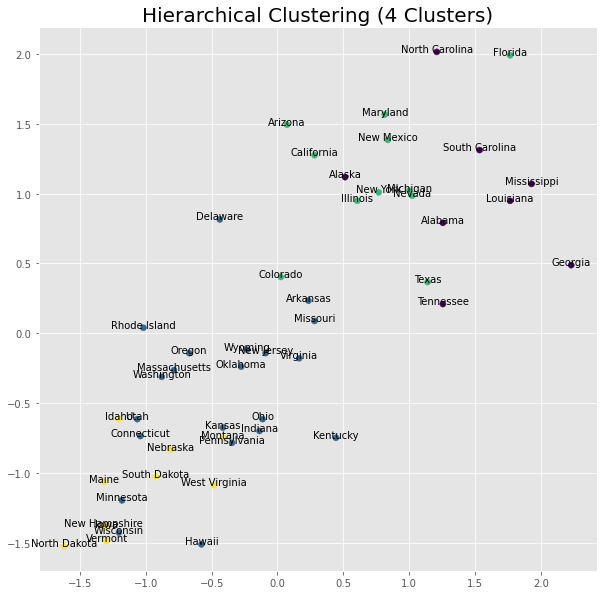

Cluster 1: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']
Cluster 2: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Missouri', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']
Cluster 3: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 4: ['Idaho', 'Iowa', 'Maine', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia']


In [97]:
fig,ax1 = plt.subplots()
agg_cluster_model = AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=4)
y_pred = agg_cluster_model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o")
for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)
plt.title('Hierarchical Clustering (4 Clusters)', fontsize = 20)
plt.savefig('hierarchical-cluster.png')
plt.show()

cluster1 = df2[agg_cluster_model.labels_==0].tolist()
cluster2 = df2[agg_cluster_model.labels_==1].tolist()
cluster3 = df2[agg_cluster_model.labels_==2].tolist()
cluster4 = df2[agg_cluster_model.labels_==3].tolist()
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)
print('Cluster 3:', cluster3)
print('Cluster 4:', cluster4)

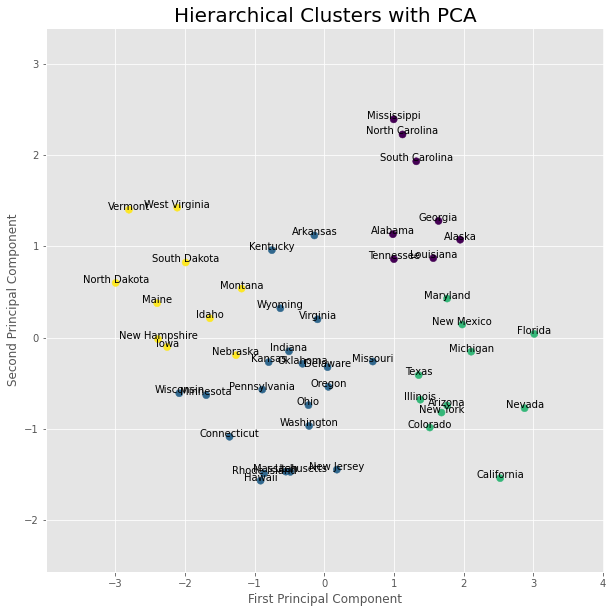

In [98]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, s=50)

for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('Hierarchical Clusters with PCA', fontsize = 20)
plt.savefig('hierarchical-cluster-pca.png')
plt.show()

**Interpretation:** The results are slightly different from the k-means. The data now is still split into four sections, but some of the states belong in different clusters.

## DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996. It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

Estimated number of clusters: 4
Estimated number of noise points: 10


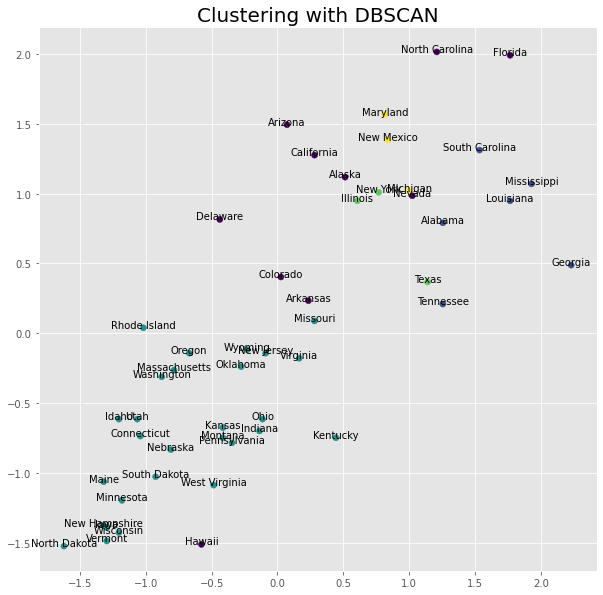

Cluster 1: ['Alabama', 'Georgia', 'Louisiana', 'Mississippi', 'South Carolina', 'Tennessee']
Cluster 2: ['Connecticut', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 3: ['Illinois', 'New York', 'Texas']
Cluster 4: ['Maryland', 'Michigan', 'New Mexico']


In [99]:
from sklearn.cluster import DBSCAN

db_model = DBSCAN(eps=1, min_samples=2)
db_model.fit(X)
y_pred = db_model.fit_predict(X)

labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
fig,ax1 = plt.subplots()

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o"); 

for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)
plt.title('Clustering with DBSCAN', fontsize = 20)
plt.savefig('dbscan.png')
plt.show()

cluster1 = df2[db_model.labels_==0].tolist()
cluster2 = df2[db_model.labels_==1].tolist()
cluster3 = df2[db_model.labels_==2].tolist()
cluster4 = df2[db_model.labels_==3].tolist()
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)
print('Cluster 3:', cluster3)
print('Cluster 4:', cluster4)

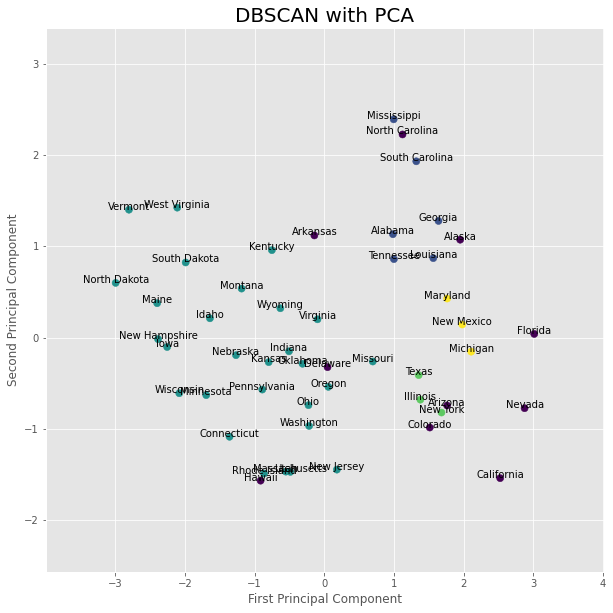

In [100]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, s=50)

for i,name in enumerate(df['Unnamed: 0'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('DBSCAN with PCA', fontsize = 20)

plt.savefig('dbscan-pca.png')
plt.show()

These results on the PCA plot is a lot different than before. The DBSCAN is extremely sensitive to the changes in epsilon in the dataset.